# Binomial logistic regression in numpy

In this notebook we will refresh our knowledge of linear models. This notebook assumes familiarity with basic machine learning concepts. See "Resources" section for material if you are unfamiliar with some of the concepts.

Your tasks will be:

* Implement binary logistic regression using numpy
* Implement SGD training loop 

Goal is to:

* Get accustomed with the environment and grading
* Refresh our numpy skills
* Refresh our machine learning knowledge

Next up:

* Implementing multinomial logistic regression in PyTorch


## Resources

If content of this notebook is new, confusing or difficult - don't worry! Check out the following resources:
* Logistic regression:  https://www.coursera.org/learn/neural-networks-deep-learning/lecture/yWaRd/logistic-regression-cost-function


# Imports, data

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import tqdm
import json

from keras.datasets import fashion_mnist
from keras.utils import np_utils

%matplotlib inline
import matplotlib.pylab as plt

import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['figure.figsize'] = (7, 7)
mpl.rcParams['axes.titlesize'] = 12
mpl.rcParams['axes.labelsize'] = 12

/home/kg/miniconda3/envs/nn2018/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Get FashionMNIST (see 1b_FMNIST.ipynb for data exploration)
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Logistic regression needs 2D data
x_train = x_train.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)

# 0-1 normalization
x_train = x_train / 255.
x_test = x_test / 255.

# For simplicity - implicit bias
x_train = np.concatenate([np.ones_like(x_train[:, 0:1]), x_train], axis=1)
x_test = np.concatenate([np.ones_like(x_test[:, 0:1]), x_test], axis=1)

# Use only first 1k examples. Just for notebook to run faster
x_train, y_train = x_train[0:1000], y_train[0:1000]
x_test, y_test = x_test[0:1000], y_test[0:1000]

# Cast as binary
y_train = (y_train == 0).astype("int")
y_test = (y_test == 0).astype("int")

## Numpy primer

This section introduces useful concepts from Numpy to complete the notebook

<img src="https://github.com/gmum/nn2018/raw/master/lab/fig/2/python-comic-2.png">

In [3]:
a = np.array([1, 2, 3, 4])
print("a: ", a)
print("Pierwszy element: ", a[0])
print("Drugi element!: ", a[1])
print("a+1:", a + 1)
print("2*a:", 2*a)
b = np.array([1, 2, 3, 4])
print("b: ", b)
print("Iloczyn skalarny <a,b>: ", np.inner(a,b))

a:  [1 2 3 4]
Pierwszy element:  1
Drugi element!:  2
a+1: [2 3 4 5]
2*a: [2 4 6 8]
b:  [1 2 3 4]
Iloczyn skalarny <a,b>:  30


# Logistic regression

## Model


Class prediction is given by:

<br>
<font size=4>
$ p(\textbf{y = 1} | \textbf{x}, \textbf{w}) = \sigma(\langle\textbf{w}, \textbf{x}\rangle)$
</font>

, where $\sigma(z) = \frac{1}{1 + \exp(-z)}$.

http://www.deeplearningbook.org/, Ch.1.

<img width=600 src="https://github.com/gmum/nn2018/raw/master/lab/fig/1/fig4.png">


Loss is given by the cross-entropy loss:

<br>
<font size=4>
$ L(\textbf{w}) = - \frac{1}{N} (\sum_i y_i \log(p(\textbf{y=1} | \textbf{x_i}, \textbf{w})) + (1 - y_i) \log(1 - p(\textbf{y=1} | \textbf{x_i}, \textbf{w})))$
</font>


Ref: https://github.com/jcjohnson/pytorch-examples

# Gradient Descent


<img width=300 src="https://github.com/gmum/nn2018/raw/master/lab/fig/2/gd.png">
<br>

## Logistic regression

<img width=600 src="https://github.com/gmum/nn2018/raw/master/lab/fig/2/graph_logreg.png">
<br>

Gradient of the loss is given by:

<br>
<font size=5>
$ \frac{\partial L(\textbf{w})}{\partial \textbf{w}_i} = \frac{1}{N} \sum_{i=1}^{N} \frac{\partial L(\textbf{x_i, w})}{\partial \textbf{w}_i} = \frac{1}{N} \sum_{i=1}^{N} x_i (p_j - y_j)$
</font>

, where $p_i$ denotes prediction of the model on $i^{th}$ example


# Implementation

In [4]:
def cross_entropy_loss(y_pred, y):
    """
    Parameters
    ----------
    y_pred: np.arrary, shape: (batch_size,)
        Probabiities
    y: np.array, shape: (batch_size,)
        Correct classes
    
    Returns
    -------
    loss: float
        Cross entropy loss
    """
    return - np.mean(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))

def sigmoid(z): 
    """
    Parameters
    ----------
    z: np.arrary, shape: (batch_size,)
        Logits

    Returns
    -------
    y_pred: np.arrary, shape: (batch_size,)
        Probabiities
    """
    return 1 / (1 + np.exp(-z))


def gradient(y_pred, y, x): 
    """
    Parameters
    ----------
    y_pred: np.arrary, shape: (batch_size,)
        Probabiities
    y: np.array, shape: (batch_size,)
        Correct classes
    x: np.array, shape: (batch_size, D)
        Logits
        
    Returns
    -------
    grad: np.array, shape: (D, )
        Array representing gradient of loss wrt to weight vector
    """
    batch_size = len(y)
    r = (y_pred - y).reshape(1, batch_size)
    return (r.T * x).mean(axis=0)

def forward(x, w):
    return sigmoid(x.dot(w))

def evaluate(w):
    y_test_pred = forward(x_test, w)
    return np.mean((y_test_pred>0.5) == y_test)

In [5]:
# Asserts to help you implement the functions.
D = 785

x = x_train[0:100]
y = y_train[0:100]
w = 0.01*np.ones_like(x_train[0, :])
y_pred = forward(x, w)

yours = forward(x, w)[0:4]
correct = [0.95257767, 0.96536256, 0.75657633, 0.86287448]
assert np.allclose(yours, correct, atol=0.01)

yours = cross_entropy_loss(y_pred, y)
correct = 2.087
assert np.abs(yours - correct) < 0.01

yours = gradient(y_pred, y, x)[0:4]
correct = [7.53742754e-01, 0.00000000e+00, 0.00000000e+00, 3.50197809e-05]
assert np.allclose(yours, correct, atol=0.01)

In [6]:
def train_logistic_regression(lr=0.1, n_epochs=100, batch_size=100):
    """
    Parameters
    ----------
    lr: float
        Learning rate used in SGD
    n_epochs: int
        Number of epochs to train
    use_autograd: bool
        If true will use PyTorch autograd
    
    Returns
    -------
    w: np.array, shape: (D_in, D_out)
        Found parameters
    """
    
    n_epochs = 100
    batch_size = 100
    learning_rate = 0.1

    # 784 + bias -> 1 model
    D = 784 + 1

    # Define all Variables used in the computation
    w = np.random.normal(size=(D, ))
    
    loss_history = []
    for epoch in tqdm.tqdm(range(n_epochs), total=n_epochs):    
        for batch in range(len(x_train) // batch_size):
            # Sample data
            x_batch = x_train[batch*batch_size:(batch+1)*batch_size]
            y_batch = y_train[batch*batch_size:(batch+1)*batch_size]
            
            y_pred = forward(x_batch, w)
            loss = cross_entropy_loss(y_pred, y_batch)

            if batch == 0:
                loss_history.append(loss)

            # Compute grad_w
            grad_w = gradient(y_pred, y_batch, x_batch)

            # Update weights using gradient descent
            w -= learning_rate * grad_w

    plt.plot(loss_history)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    
    return w

# Tests

Each notebook will terminate with Tests section. This will automatically grade and assign points.

100%|██████████| 100/100 [00:00<00:00, 119.17it/s]


Evaluation results:
{'test1': 1}


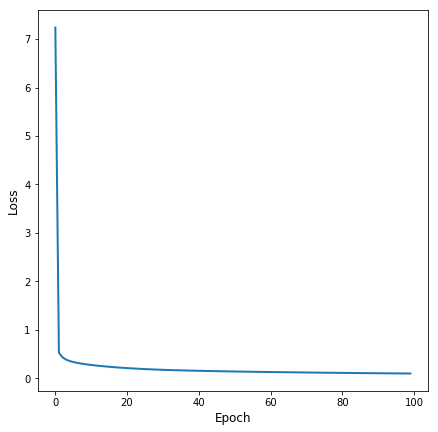

In [7]:
result = {}
result['test1'] = int(evaluate(train_logistic_regression(n_epochs=100, lr=0.1)) > 0.8)
print("Evaluation results:\n===========")
print(result)
json.dump(result, open("2a_logistic_regression.json", "w"))